In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift
)
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox
from darts.utils.timeseries_generation import datetime_attribute_timeseries

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/TimeSeries/TotalConsumption.csv')
data['TotalConsumption'] = data['Value_NE5'] + data ['Value_NE7']
data = data.drop(columns=['Value_NE5', 'Value_NE7'])
data['Timestamp'] = pd.to_datetime(data['Timestamp'], utc=True)
data.set_index('Timestamp', inplace=True)
# data = data.resample('H').sum(min_count=1)
data = data.resample('D').sum(min_count=1)
data=data.sort_index()
data['Covid'] = 0
data.loc[(data.index >= '2020-02-01') & (data.index <= '2021-06-01'), 'Covid'] = 1
# data = data.loc[data.index >= '2019-01-01']
data['TimeIndex'] = np.arange(len(data))

data = data.drop(columns=['TimeIndex'])

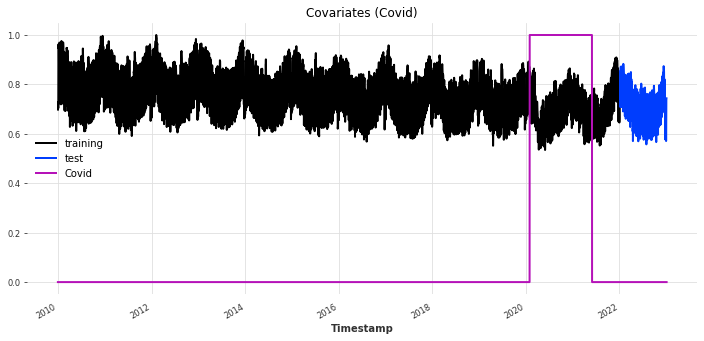

In [ ]:
from darts.dataprocessing.transformers import Scaler

series_scaler = Scaler()
series = TimeSeries.from_dataframe(df=data, value_cols='TotalConsumption')
series = series_scaler.fit_transform(series)
series = series[1:]
# split_time = 24*365
split_time = 365
train, test = series[:-split_time], series[-split_time:-1]

plt.figure(101, figsize=(12, 5))
train.plot(label='training')
test.plot(label='test')
plt.legend()

### add past covariates
covariates_covid = TimeSeries.from_dataframe(df=data, value_cols='Covid')
train_covariates_covid = covariates_covid[:-split_time]


plt.figure(101, figsize=(12, 5))
covariates_covid.plot()
plt.title("Covariates (Covid)")
### add future covariates
covariates_scaler = Scaler()
series_year = datetime_attribute_timeseries(series, attribute="year")
series_month = datetime_attribute_timeseries(series, attribute="month")
series_weekday = datetime_attribute_timeseries(series, attribute="weekday")
# series_hour = datetime_attribute_timeseries(series, attribute="hour")
covariates = series_year.stack(series_month).stack(series_weekday)#.stack(series_hour)
covariates = covariates_scaler.fit_transform(covariates)
train_covariates, test_covariates = covariates[:-split_time], covariates[-split_time-21:-1]


# plt.figure(101, figsize=(12, 5))
# covariates[0:10*24].plot()
# plt.title("Covariates (year, month, weekday and hour)")
past_covariates_scaler = Scaler()
past_covariates = covariates_covid[1:].stack(series_year).stack(series_month).stack(series_weekday)
past_covariates = past_covariates_scaler.fit_transform(past_covariates)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
is_daily_seasonal, daily_period = check_seasonality(series, m=7, max_lag=400, alpha=0.05)
is_weekly_seasonal, weekly_period = check_seasonality(series, m=365, max_lag=400, alpha=0.05)

print(f'Daily seasonality: {is_daily_seasonal} - period = {daily_period}')
print(f'Weekly seasonality: {is_weekly_seasonal} - period = {weekly_period}')

Daily seasonality: True - period = 7
Weekly seasonality: False - period = 365


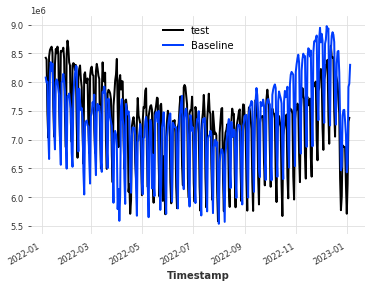

In [ ]:
test_unsc = series_scaler.inverse_transform(test)
train_unsc = series_scaler.inverse_transform(train)

naive_seasonal = NaiveSeasonal(K=365)
naive_seasonal.fit(train_unsc)
pred_naive = naive_seasonal.predict(365)
test_unsc.plot(label='test')
pred_naive.plot(label='Baseline')

In [ ]:
naive_mae = mae(test, pred_naive)
naive_mape = mape(test, pred_naive)
print(naive_mae)
print(naive_mape)

7289305.8249682095
995204650.0111153


In [ ]:
from darts.models import TFTModel

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping
from torchmetrics import MeanAbsolutePercentageError

# A TorchMetric or val_loss can be used as the monitor
torch_metrics = MeanAbsolutePercentageError()

# Early stop callback
my_stopper = EarlyStopping(
    monitor="train_loss",  # "val_loss",
    patience=2,
    # min_delta=0.005,
    mode='min',
)
pl_trainer_kwargs = {"callbacks": [my_stopper]}

tft = TFTModel(
    input_chunk_length=28,
    output_chunk_length=7,
    hidden_size=32,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    random_state=8,
    # add_encoders=None,
    # loss_fn=torch.nn.MSELoss,
    # optimizer_cls=torch.optim.Adam,
    optimizer_kwargs={'lr': 1e-3},
    torch_metrics=torch_metrics,
    pl_trainer_kwargs=pl_trainer_kwargs
)

In [ ]:
tft.fit(train, 
future_covariates=train_covariates,
past_covariates=train_covariates_covid,
epochs=50,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.0 K 
5  | decoder_vsn                       | _Vari

Training: 0it [00:00, ?it/s]

In [ ]:
train_covariates, test_covariates = covariates[:-split_time], covariates[-split_time-364:]

In [ ]:
scaled_pred_tft = tft.predict(n=365, future_covariates=test_covariates, past_covariates=covariates_covid)
pred_tft = series_scaler.inverse_transform(scaled_pred_tft)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

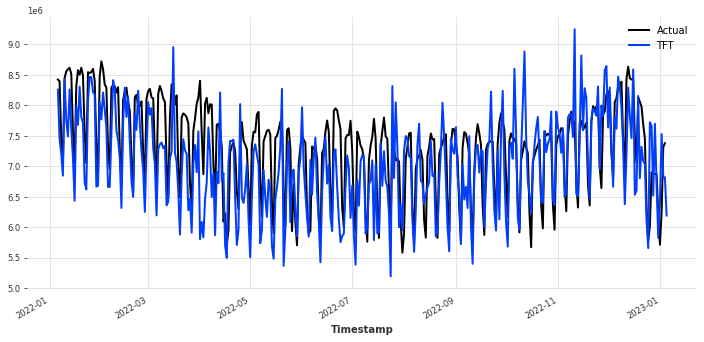

In [ ]:
plt.figure(101, figsize=(12, 5))
test_unsc.plot(label='Actual')
pred_tft.plot(label='TFT')

In [ ]:
tft_mae = mae(test, pred_tft)
tft_mape = mape(test, pred_tft)
print(tft_mae)
print(tft_mape)

7027915.729691302
955906118.674077


In [ ]:
#28/7
#21/7 -> 0.0495
#21/1 -> 0.0444
#14/7 -> 0.0462
#14/1 -> 0.0447
#7/1 -> 0.0469

In [ ]:
from darts.models import TCNModel

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping
from torchmetrics import MeanAbsolutePercentageError

# A TorchMetric or val_loss can be used as the monitor
torch_metrics = MeanAbsolutePercentageError()

# Early stop callback
my_stopper = EarlyStopping(
    monitor="train_loss",  # "val_loss",
    patience=2,
    # min_delta=0.005,
    mode='min',
)
pl_trainer_kwargs = {"callbacks": [my_stopper]}

deeptcn = TCNModel(
    dropout=0.2,
    batch_size=32,
    n_epochs=20,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    input_chunk_length=2*365,
    output_chunk_length=365,
    kernel_size=3,
    num_filters=4
)

deeptcn.fit(series=train, past_covariates=past_covariates, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 834   
----------------------------------------------------
834       Trainable params
0         Non-trainable params
834       Total params
0.007     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
scaled_pred_tcn = deeptcn.predict(n=365, past_covariates=past_covariates)
pred_tcn = series_scaler.inverse_transform(scaled_pred_tcn)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

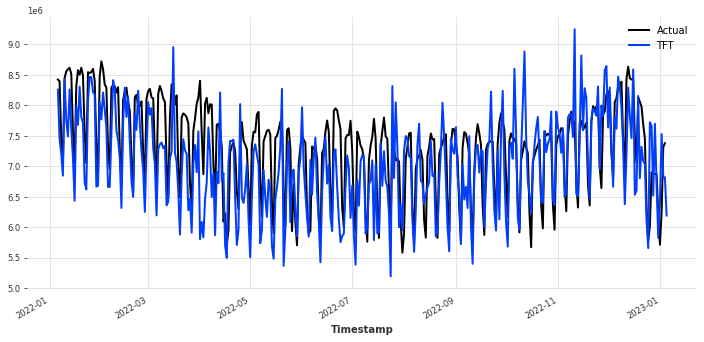

In [ ]:
plt.figure(101, figsize=(12, 5))
test_unsc.plot(label='Actual')
pred_tft.plot(label='TFT')

In [ ]:
tcn_mae = mae(test, pred_tcn)
tcn_mape = mape(test, pred_tcn)
print(tcn_mae)
print(tcn_mape)

6888493.86164525
939465387.6565539


In [ ]:
from darts.models import TransformerModel

In [ ]:
# A TorchMetric or val_loss can be used as the monitor
torch_metrics = MeanAbsolutePercentageError()

# Early stop callback
my_stopper = EarlyStopping(
    monitor="train_loss",  # "val_loss",
    patience=2,
    # min_delta=0.005,
    mode='min',
)
pl_trainer_kwargs = {"callbacks": [my_stopper]}


tm = TransformerModel(
    input_chunk_length=14,
    output_chunk_length=1,
    batch_size=32,
    torch_metrics=torch_metrics,
    pl_trainer_kwargs=pl_trainer_kwargs
)
tm.fit(train,
past_covariates=past_covariates,
epochs=50
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 384   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 65    
------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Tot

Training: 0it [00:00, ?it/s]

In [ ]:
scaled_pred_tm = tm.predict(n=365, past_covariates=past_covariates)
pred_tm = series_scaler.inverse_transform(scaled_pred_tm)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

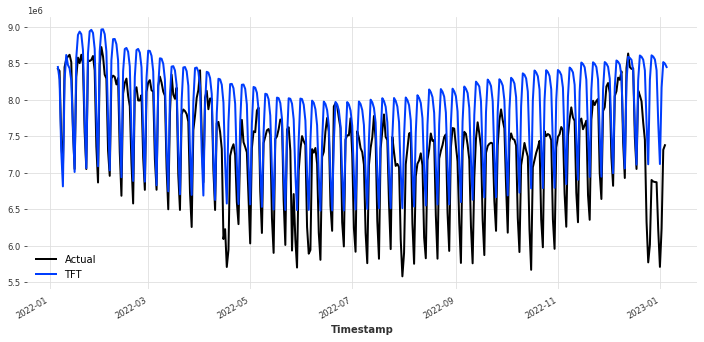

In [ ]:
plt.figure(101, figsize=(12, 5))
test_unsc.plot(label='Actual')
pred_tm.plot(label='TFT')

In [ ]:
tm_mae = mae(test, pred_tm)
tm_mape = mape(test, pred_tm)
print(tm_mae)
print(tm_mape)

7844146.849978054
1067906419.2006118


In [ ]:
from darts.models import RNNModel, BlockRNNModel

In [ ]:
# A TorchMetric or val_loss can be used as the monitor
torch_metrics = MeanAbsolutePercentageError()

# Early stop callback
my_stopper = EarlyStopping(
    monitor="train_loss",  # "val_loss",
    patience=2,
    # min_delta=0.005,
    mode='min',
)
pl_trainer_kwargs = {"callbacks": [my_stopper]}

rnn = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0.1,
    batch_size=32,
    training_length=30,
    input_chunk_length=14,
    torch_metrics=torch_metrics,
    pl_trainer_kwargs=pl_trainer_kwargs
)

rnn.fit(train,
future_covariates=past_covariates,
epochs=50
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.2 K 
4 | V             | Linear           | 21    
---------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.017     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
scaled_pred_rnn = rnn.predict(n=365, future_covariates=past_covariates)
pred_rnn = series_scaler.inverse_transform(scaled_pred_rnn)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

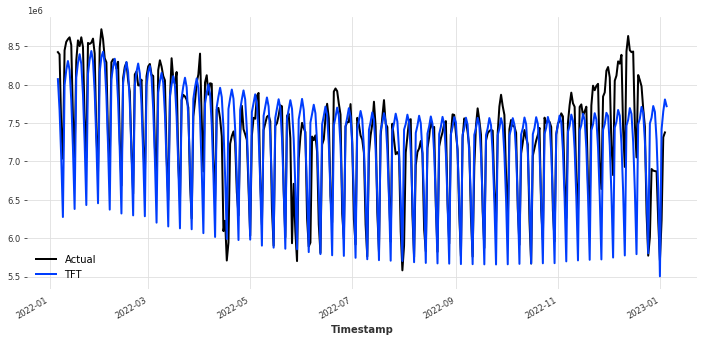

In [ ]:
plt.figure(101, figsize=(12, 5))
test_unsc.plot(label='Actual')
pred_rnn.plot(label='TFT')

In [ ]:
rnn_mae = mae(test, pred_rnn)
rnn_mape = mape(test, pred_rnn)
print(rnn_mae)
print(rnn_mape)

7249114.992386312
985424839.6717751


In [ ]:
# A TorchMetric or val_loss can be used as the monitor
torch_metrics = MeanAbsolutePercentageError()

# Early stop callback
my_stopper = EarlyStopping(
    monitor="train_loss",  # "val_loss",
    patience=2,
    # min_delta=0.005,
    mode='min',
)
pl_trainer_kwargs = {"callbacks": [my_stopper]}


brnn = BlockRNNModel(
    model="LSTM",
    input_chunk_length=30,
    output_chunk_length=1,
    hidden_dim=10,
    n_rnn_layers=1,
    batch_size=32,
    dropout=0.1,
    torch_metrics=torch_metrics,
    pl_trainer_kwargs=pl_trainer_kwargs
)

brnn.fit(train,
past_covariates=past_covariates,
epochs=50
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 680   
4 | fc            | Sequential       | 11    
---------------------------------------------------
691       Trainable params
0         Non-trainable params
691       Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
scaled_pred_brnn = brnn.predict(n=365, past_covariates=past_covariates)
pred_brnn = series_scaler.inverse_transform(scaled_pred_brnn)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

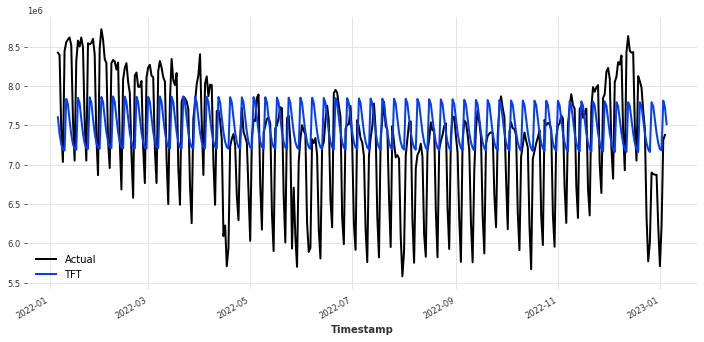

In [ ]:
plt.figure(101, figsize=(12, 5))
test_unsc.plot(label='Actual')
pred_brnn.plot(label='TFT')

In [ ]:
brnn_mae = mae(test, pred_rnn)
brnn_mape = mape(test, pred_rnn)
print(brnn_mae)
print(brnn_mape)

7249114.992386312
985424839.6717751


In [ ]:
from darts.models import NHiTSModel

In [ ]:
# A TorchMetric or val_loss can be used as the monitor
torch_metrics = MeanAbsolutePercentageError()

# Early stop callback
my_stopper = EarlyStopping(
    monitor="train_loss",  # "val_loss",
    patience=2,
    # min_delta=0.005,
    mode='min',
)
pl_trainer_kwargs = {"callbacks": [my_stopper]}


nhits = NHiTSModel(
    input_chunk_length=28, 
    output_chunk_length=7,
    torch_metrics=torch_metrics,
    pl_trainer_kwargs=pl_trainer_kwargs
    )



nhits.fit(train,
past_covariates=past_covariates,
epochs=50
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.1 M 
---------------------------------------------------
1.0 M     Trainable params
71.8 K    Non-trainable params
1.1 M     Total params
8.793     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
scaled_pred_nhits = nhits.predict(n=365, past_covariates=past_covariates)
pred_nhits = series_scaler.inverse_transform(scaled_pred_nhits)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

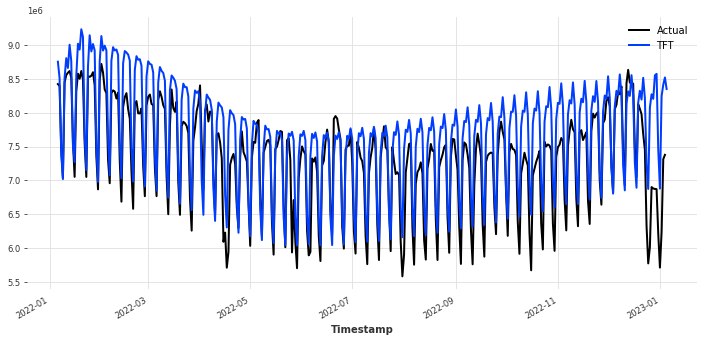

In [ ]:
plt.figure(101, figsize=(12, 5))
test_unsc.plot(label='Actual')
pred_nhits.plot(label='TFT')

In [ ]:
nhits_mae = mae(test, pred_nhits)
nhits_mape = mape(test, pred_nhits)
print(nhits_mae)
print(nhits_mape)

7695323.917433411
1045658615.8135259


In [ ]:
from darts.models import RegressionModel

regr_model = RegressionModel(lags=365,
                             lags_past_covariates=None, 
                             lags_future_covariates=[-6,-5,-4, -3, -2, -1, 0])

regr_model.fit(train,
               #past_covariates=past_covariates,
               future_covariates=past_covariates)

In [ ]:
scaled_pred_regr = regr_model.predict(n=365, future_covariates=past_covariates)
pred_regr = series_scaler.inverse_transform(scaled_pred_regr)

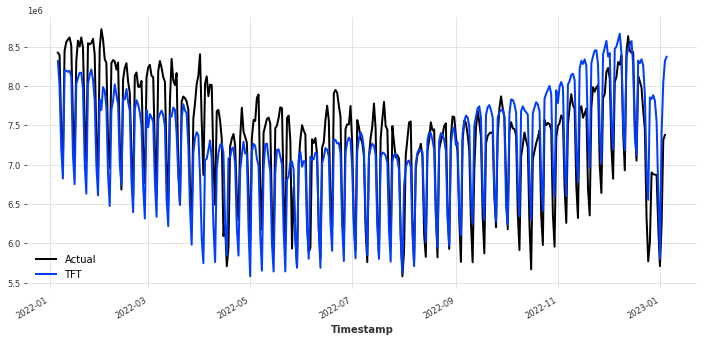

In [ ]:
plt.figure(101, figsize=(12, 5))
test_unsc.plot(label='Actual')
pred_regr.plot(label='TFT')

In [ ]:
print(mae(test, pred_regr))
print(mape(test, pred_regr))

7333109.460589874
997518140.1481323
